# Machine learning approach for risk-based inspection screening assessment
This notebook describes the implementation of machine approach in the risk-based inspection (RBI) screening assessment, as described in the paper ['*Machine learning approach for risk-based inspection screening assessment*'](https://www.sciencedirect.com/science/article/pii/S0951832018301662). This notebook is focused on the model development aspects of the paper. Some aspects, such as statistic test and comparative analysis of machine learning algorithm and human appraisers are excluded. Please refer to the paper for more explanation.

The abstract of the paper is shown below:
> *Risk-based inspection (RBI) screening assessment is used to identify equipment that makes a significant contribution to the system's total risk of failure (RoF), so that the RBI detailed assessment can focus on analyzing higher-risk equipment. Due to its qualitative nature and high dependency on sound engineering judgment, screening assessment is vulnerable to human biases and errors, and thus subject to output variability and threatens the integrity of the assets. This paper attempts to tackle these challenges by utilizing a machine learning approach to conduct screening assessment. A case study using a dataset of RBI assessment for oil and gas production and processing units is provided, to illustrate the development of an intelligent system, based on a machine learning model for performing RBI screening assessment. The best performing model achieves accuracy and precision of 92.33% and 84.58%, respectively. A comparative analysis between the performance of the intelligent system and the conventional assessment is performed to examine the benefits of applying the machine learning approach in the RBI screening assessment. The result shows that the application of the machine learning approach potentially improves the quality of the conventional RBI screening assessment output by reducing output variability and increasing accuracy and precision.*

# 1.0. Introduction
The advancement of inspection and maintenance strategies from a conventional calendar-based approach to more sophisticated plans, such as condition-monitoring, reliability-centered maintenance, and risk-based approach, has been driven by the increase in the number, size, and complexity of physical assets. These advanced strategies help organizations to maximize the availability and reliability of the equipment, while still ensuring that operations are safe for the personnel, society, and environment. One of these strategies is risk-based inspection (RBI), which shifts the inspection planning paradigm from time-based inspection planning to more proactive inspection planning, by using a risk-based approach. RBI allows organizations to focus their inspection resources on equipment with a high risk of failure, thus preventing over-inspection of lower-risk equipment and under- inspection of higher-risk equipment.

![Title](Images/RBI_workflow.png)

A generic RBI planning process is presented in the figure above. For detailed information and an explanation regarding RBI methodology, refer to the API RP 580 and DNV GL RP-G101. Normally, there are two types of risk assessment in an RBI planning process: (1) screening assessment and (2) detailed assessment. Screening and detailed assessment differ in terms of the level of detail in estimating the equipment’s risk level. Screening assessment typically utilizes qualitative analysis, which has a simpler procedure, fewer data requirements, and faster analysis time than the quantitative approach. Meanwhile, detailed assessment typically uses a quantitative approach.that requires more data and has a more rigorous computation and analysis procedure than qualitative analysis. Computer software is commonly used to generate outputs related to detailed assessment.

In most processing systems, a significant portion of the system’s total risk is accumulated in a relatively small percentage of the items of equipment. Therefore, a screening assessment is conducted prior to the detailed assessment, to identify equipment that makes a significant contribution to the system’s overall risk. This allows the detailed assessment to focus on higher-risk items; thus, resources (e.g., time and labor) can be allocated more effectively and efficiently.

However, there are two fundamental challenges in performing screening assessment. First, because of its qualitative nature, screening assessment depends more on the knowledge, expertise, and judgement of the engineering personnel, which makes it prone to human biases and errors. Moreover, qualitative assessment, based on subjective judgement and limited data and information, causes considerable variability in outputs. Additionally, human error is inevitable, due to the limitation of the human mind in processing and storing information. The variability of outputs and errors can undermine the integrity of the physical assets, by causing incongruity between the equipment risk level and the inspection quality and characteristics (e.g., inspection frequency, method, and level of detail). Second, considerable time and resources are needed to perform qualitative analysis. Organizations may need to gather personnel from different departments (e.g., process, safety, asset integrity, inspection, etc.) to decide whether certain equipment needs to be included in the detailed assessment. It is possible to avoid the screening assessment entirely and include all equipment in the RBI detailed assessment, but this option can be costly, considering the laborious and rigorous nature of the detailed assessment process.

This study attempts to address the aforementioned challenges by developing an intelligent system, based on the machine learning approach. Machine learning enables transfer and reuse of past RBI detailed assessments, by mechanizing knowledge acquisition and converting existing data and information into actionable knowledge. In other words, the intelligent system enables past RBI detailed assessments’ data and information to be utilized as the references for conducting the new RBI screening assessment. This approach is expected to reduce the inherent output variability in qualitative analysis, as the machine learning algorithm is less susceptible to human errors and biases than human workers. Furthermore, the intelligent system can provide instantaneous RBI screening assessment results, which is the basis for reducing the time and effort involved in carrying out RBI analysis. The schematic of the suggested approach is displayed in the figure below.

![title](Images/ML_schematic_for_RBI.png)

Before starting to develop machine learning models, we need to import the necessary packages.

In [1]:
# Import data analysis packages
import pandas as pd
import numpy as np

# Import feature/model selection and feature preprocessing packages
from sklearn.preprocessing import minmax_scale, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

# Import machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Import metrics packages
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score 

# Importing data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Miscellaneous
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import xlrd

The steps required to develop the machine learning model for RBI screening assessment are shown in the figure below. Each step is discussed individually in the following sections.

![title](Images/ML_workflow.png)

# 2.0. Data import
The dataset used in this paper was obtained from an RBI assessment project conducted for three onshore and four offshore production units. The scope of the project was to perform an RBI detailed assessment for these units, comprising over 200 pressure vessels and 3000 piping tags, based on API 581 methodology. 

In [2]:
# Create a function to import excel files
def import_excel(file, sheet_name):
    file = xlrd.open_workbook(file)
    sheet = file.sheet_by_name(sheet_name)
    columns = sheet.row_values(0)
    data = []
    for i in range(1,sheet.nrows):
        row = sheet.row_values(i)
        data.append(row)
    df = pd.DataFrame(data, columns=columns)
    _, unique_columns = np.unique(df.columns, return_index=True)
    df = df.iloc[:, unique_columns]
    df.set_index("Component", inplace=True)
    return df

# Import the data by using the function
df_F1 = import_excel('Data/Complete Result - F1 - Rev1.xlsx', "Complete Export")
df_F2 = import_excel('Data/Complete Result - F2 - Rev1.xlsx', "Complete Export")
df_F3 = import_excel('Data/Complete Result - F3 - Rev2.xlsx', "Complete Export")
df_F4 = import_excel('Data/Complete Result - F4 - Rev0.xlsx', "Complete Export")
df_F5 = import_excel('Data/Complete Result - F5 - Rev1.xlsx', "Complete Export")
df_F6 = import_excel('Data/Complete Result - F6 - Rev0.xlsx', "Complete Export")
df_F7 = import_excel('Data/Complete Result - F7 - Rev1.xlsx', "Complete Export")

# Combine all data into one dataframe
df_origin = pd.concat([df_F1, df_F2, df_F3, df_F4, df_F5, df_F6, df_F7])

# 3.0. Feature selection
Feature selection is the process of choosing a subset of input features that contribute the most to the output feature for use in model construction. Feature selection is substantially important if we have datasets with high dimensionality (i.e., large number of features). High-dimensional datasets are not preferred because they have lengthy training time and have high risk of overfitting. 

In this study, a systematic feature selection is performed by the combination of domain knowledge and data-driven approach. The complete feature selection process used in this study is shown below. Each step is discussed individually in the following subsections.

![title](Images/feature_selection_workflow.png)

## 3.1. Exclude features that have missing values
Most machine learning algorithms cannot handle missing values. In this study, features that contain missing values are excluded, to prevent errors in the learning algorithms.

In [3]:
# Replace empty values with NaN
df_origin.replace(['',' '], [np.nan,np.nan], inplace=True)

# Remove all instances that do not have risk result
df = df_origin.loc[~df_origin['Risk Matrix'].isna()]
df.drop(1.0, axis=0, inplace=True)

# Make a list of features that have no missing values
missing_data = df.isna().sum()/df.shape[0] * 100
no_miss_features = list(missing_data[missing_data == 0].index)

# Include only features that have no missing values
df = df[no_miss_features]

## 3.2. Exclude duplicate features 
A feature is considered a duplicate if it contains the same information as another feature. The following features are excluded:
- *Process_Fluid* and *Fluid_Name* contain the same information. *Fluid_Name* is removed.
- *Equipment Type* is the general version of *Component Type*. *Equipment Type* is eliminated. 
- *BM_CODE* and *Design_Code* contain the same information. 
- *BM_CODE* and *Design_Code* is the general version of *Component Type*. *BM_CODE* and *Design_Code* are eliminated.
- *Component Type* and *Component_Type* contain the same information. *Component_Type* is removed.

In [4]:
# Remove Fluid_Name, Equipment_Type, BM_CODE, Design_Code, and Component_Type
df.drop(columns=['Fluid_Name', 'Equipment_Type', 'BM_CODE', 'Design_Code', 'Component_Type'], inplace=True)

## 3.3. Remove features that cause information leakage
Information leakage happens when the training dataset contains features that the model is trying to predict. To prevent information leakage, features that are generated as part of the RBI assessment outputs (i.e., output features) are not selected as the input features.

In [5]:
#RBI output related features
output_feats = ["COF", "Equipment Linings", 
                "Financial_Cost", "Financial_Risk", "Maximum_Risk", 
                "POF", "Risk Category", "Risk_Brittle_Fracture_At_Plan_Date_No_Inspection", 
                "Risk_Brittle_Fracture_At_Plan_Date_With_Inspection", "Risk_Brittle_Fracture_At_RBI_Date", 
                "Risk_Brittle_Fracture_At_Tar_Years", "Risk_Category_At_RBI_Date", 
                "Risk_Cracking_At_Plan_Date_No_Inspection", "Risk_Cracking_At_Plan_Date_With_Inspection", 
                "Risk_Cracking_At_RBI_Date", "Risk_Cracking_At_Tar_Years", 
                "Risk_External_Damage_At_Plan_Date_No_Inspection", "Risk_External_Damage_At_Plan_Date_With_Inspection", 
                "Risk_External_Damage_At_RBI_Date", "Risk_External_Damage_At_Tar_Years", 
                "Risk_Fatigue_At_Plan_Date_No_Inspection", "Risk_Fatigue_At_Plan_Date_With_Inspection", 
                "Risk_Fatigue_At_RBI_Date", "Risk_Fatigue_At_Tar_Years", "Risk_HTHA_At_Plan_Date_No_Inspection", 
                "Risk_HTHA_At_Plan_Date_With_Inspection", "Risk_HTHA_At_RBI_Date", "Risk_HTHA_At_Tar_Years", 
                "Risk_Thinning_At_Plan_Date_No_Inspection", "Risk_Thinning_At_Plan_Date_With_Inspection", 
                "Risk_Thinning_At_RBI_Date", "Risk_Thinning_At_Tar_Years", "Target_Date", 
                "Tot_Risk_Grad_Plan", "Tot_Risk_Grad_Plan_NI", "Tot_Risk_Grad_RBI_Date", "Tot_Risk_Grad_Tar_Years_NI", 
                "Total_DF", "Total_Risk_At_Plan_Date_No_Inspection", "Total_Risk_At_Plan_Date_With_Inspection", 
                "Total_Risk_At_RBI_Date", "Total_Risk_At_Tar_Years"]

#Remove features that cause information leakage
df.drop(columns=output_feats, inplace=True)

## 3.4. Remove features with intensive data gathering and assessment
Considering the simplistic nature of RBI screening assessment, features that require intensive data gathering and assessment are removed. For instance, some features contained in the dataset (i.e., damage mechanism- and inspection-related features) are generated as the results of RBI detailed assessment, making them unsuitable as input features, due to heavy pre-assessment and pre-computation.

In [6]:
#Damage Mechanism Characteristics
DM_feats = ['885 F Embrittlement', 'Amine Cracking', 'BM_Corrosion_Rate', 'Bundle Damage',
            'CUI Austenitic Stainless Steels', 'CUI Carbon & Low Alloy Steels', 'Carbonate Cracking',
            'Caustic Cracking', 'Chloride Cracking', 'Damage_ID', 'Damage_Type',
            'External Corrosion Carbon & Low Alloy Steels', 'External SCC Of Austenitic Stainless Steels',
            'HIC SOHIC H2S', 'HIC SOHIC HF', 'HSC HF', 'HTHA Damage', 'Low Temperature Brittle Fracture',
            'Mechanical Fatigue', 'Other Cracking', 'Polythionic Acid Cracking', 'SSC H2S', 
            'Sigma Phase Embrittlement', 'Temper Embrittlement', 'Thinning Damage', 'Thinning_Type',
            'Damage_Calculation_Flag', 'Hydrogen_Partial_Pres', 'Geometry_Type', 'Percent_Toxic']

#Inspection Characteristics and History
insp_feats = ["Date Thinning Inspection", "Ext Damage Inspection Type", "HTHA_Future_Insp_Type", 
              "Insp_Date_Plan_HTHA", "Inspection_Method", "Inspection_Option", 
              "Inspection_Plan_Basis", "Thinning Inspection Type", "Cracking Inspection Type", 
              "Date Cracking Inspection", "Date Ext Damage Inspection"]

#Inventory Group
inv_feats = ['Inventory_Group', 'InvGrp_Liquid_Mass']

#Length
dim_feats = ['Length']

#Mitigation System
mitigation_system = ['Mitigation_System', 'Detection_System']

# All features with intensive data gathering and assessment
int_feats = DM_feats + insp_feats + inv_feats + dim_feats + mitigation_system

#Remove features that cause information leakage
df.drop(columns=int_feats, inplace=True)

In addition, features related to software general setting and asset identifier are removed because they do not contribute in risk predictions. 

In [7]:
#RBI general setting
RBI_gen_feats = ["Area_Risk_Target", "Financial_Risk_Target", "Metric_Flag", 
                 "Plan_Date", "RBI_Date", "Toxic_Model", "DF_Target", 'External_Environment']

#Asset Identifier
Asset_ID = ["Component_Description", "Corporation", "Equipment", 
            "Count as Group", "Count as Whole Asset"]

#Remove general setting and identifier features
df.drop(columns=RBI_gen_feats + Asset_ID, inplace=True)

## 3.5. Remove zero-variance and near-zero variance features 
Zero-variance/near-zero- variance features are variables that are nearly identical and constant among instances in the dataset, making them uninformative, with little effect on the computations. In this study, a zero-variance/near- zero-variance feature is defined as a feature with a frequency ratio (i.e., the frequency of the most prevalent value to the frequency of the second most prevalent value) greater than 10. 

In [8]:
# Remove zero-variance and near-zero variance features
temp_list = list()
for col in df.columns:
    temp = [col, df[col].value_counts().values[0]/df[col].value_counts().values[1]]
    temp_list.append(temp)
freq_ratio = pd.DataFrame(temp_list)
freq_ratio.columns = ['Features', 'Freq Ratio']
freq_ratio.sort_values(['Freq Ratio'], inplace=True)
non_zero_var_feats = freq_ratio.loc[freq_ratio['Freq Ratio'] < 10, 'Features']
non_zero_var_feats = list(non_zero_var_feats)
df = df[non_zero_var_feats]

## 3.6. Remove multicollinear features
Multicollinearity among features is eliminated, due to its detrimental effect on the model generalizability. To identify multicollinearity, a correlation matrix is constructed to compute the Pearson correlation coefficient between two features. Pairwise features that have a correlation coefficient larger than 0.5 are identified. Then, the feature within the pair that has a higher average correlation coefficient with the other features is removed.

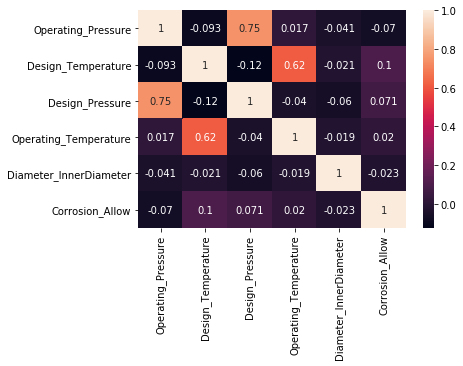

In [9]:
# Create a heatmap for the correlation matrix
sns.heatmap((df.loc[:,['Operating_Pressure', 'Design_Temperature', 'Design_Pressure', 'Operating_Temperature', 
          'Diameter_InnerDiameter', 'Corrosion_Allow']].astype('float')).corr(), annot=True)

In [10]:
# Remove Design_Pressure and Design_Temperature 
df.drop(columns=['Design_Pressure', 'Design_Temperature'], inplace=True)

# 4.0. Data Pre-Processing
Data pre-processing is performed to transform raw data into a readable and understandable format, and to cleanse cluttered and noisy data. Raw data are generally incomplete, inconsistent, and contain many errors; data pre-processing ensures that the data are prepared for further processing.

## 4.1. Generalization of features
A data transformation process that is performed on the dataset is generalization, which reduces the number of distinct values in a certain feature by replacing low-level feature values with higher-level values. Generalization is performed to avoid undergeneralization, which causes a certain feature to be uninformative and unhelpful in refining the predictive power of the model. The decision regarding how high a feature should be generalized is a subjective matter. Attribute generalization threshold control, which limits the number of distinct values in a feature, is commonly applied to prevent under-generalization. The threshold for the number of distinct values in a feature normally ranges from 2 to 8, and the determination of the threshold value should be based on expert judgment. In this study, the threshold value, which is set to 7, is applied to categorical features.

Four features are generalized: fluid containment, material of con- struction, insulation type, and risk category. The detail is shown in the table below.

![title](Images/generalized_features.png)

### 4.1.1. Material Type
The material of construction feature is generalized and transformed into four distinct values (i.e., carbon steel, SS316L, 22Cr, and aluminum) that represent higher level of abstraction in material type concept hierarchy. These four values represent material types that have different levels of resistance to various degradation mechanisms and, thus, have a distinctive impact on the probability of failure and risk of failure levels. 

In [11]:
# Create a function to generalized material types
def replace_material(value, init_string, repl_string):
    if init_string in value:
        value = repl_string
    return value

# Replace the material value with the function
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: x.split())
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A106", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA106", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A516", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA516", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "316L", "SS316L"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "TP316L", "SS316L"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A790", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A333", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA333", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA240", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA789", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "API5LDS", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA179", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA53", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA283", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A283", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA36", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A36M", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SB209", "Aluminum"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA182", "SS316L"))

### 4.1.2. Risk category 
For the risk category feature, generalization is conducted in accordance with the objective of RBI screening assessment. The risk category from the original dataset contains the probability of failure and consequence of failure classification of each item of equipment. The goal of the model is to classify whether particular equipment is in the 1A risk category (i.e., low risk) or not (i.e., medium/high risk). Thus, the risk category feature value is transformed to low class (i.e., 1A risk level) or medium/high class (i.e., higher than 1A risk level). In other words, the RBI screening assessment is essentially a binary classification task. From the dataset, 375 of the instances (23% of the total instances) are in the low-risk category, while the remaining 1206 instances (77% of the total instances) are in the medium/high class.

In [12]:
# Generalize risk category
matrix_dict = {'1A':1, '1B':0, '1C':0, '2B':0, 
               '1D':0, '1E':0, '2E':0, '2C':0, 
               '2A':0, '2D':0, '3E':0, '3B':0, 
               '3A':0,'3C':0, '4A':0, '4B':0, 
               '4C':0, '4D':0}

df["Risk Matrix"].replace(matrix_dict, inplace=True)

### 4.1.3. Process Fluid 
The fluid containment feature is generalized and transformed into three values (i.e., non-hydrocarbon, light hydrocarbon, and heavy hydrocarbon) that represent three types of fluid that give different magnitudes of consequence of failure and risk of failure.

In [13]:
# Generalize process fluid

df["Fluid_Type"] = np.NaN
#------------------------------------------------------------------------------------------------------------------
fluid_dict_CPP = {'Stream 10':0, 'Stream 14':0, 'Stream 15':0, 'Stream 17':0, 'Stream 20':0,
                  'Stream 21':0, 'Stream 22':0, 'Stream 26':2, 'Stream 27':2, 'Stream 29':2,
                  'Stream 3':2, 'Stream 31':2, 'Stream 32':2, 'Stream 36':2, 'Stream 39':2,
                  'Stream 4':2, 'Stream 40':2, 'Stream 46':1, 'Stream 47':0, 'Stream 5':2,
                  'Stream 50':0, 'Stream 54':2, 'Stream 55':2, 'Stream 57':2, 'Stream 6':2,
                  'Stream 60':2, 'Stream 62':2, 'Stream 65':2, 'Stream 67':2, 'Stream 7':2,
                  'Stream 70':2, 'Stream 72':2, 'Stream 75':2, 'Stream 78':2, 'Stream 79':2,
                  'Stream 8':2, 'Stream 81':2, 'Stream 83':2, 'Stream 84':2, 'Stream 86':2,
                  'Stream 87':2, 'Stream 88':2, 'Stream 89':2, 'Stream 9':1, 'Water':0}

df.loc[df["Plant"] == "CPP","Fluid_Type"] = df.loc[df["Plant"] == "CPP", 
                                                   "Process_Fluid"].replace(fluid_dict_CPP).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_AUP = {'Air':0, 'Diesel':1, 'Fresh Water':0, 'Sea Water':0, 'AFF':0, 'Fuel Gas':1,
                  'Lube Oil':0, 'Nitrogen':0}

df.loc[df["Plant"] == "AUP", "Fluid_Type"] = df.loc[df["Plant"] == "AUP", 
                                                    "Process_Fluid"].replace(fluid_dict_AUP).values
#------------------------------------------------------------------------------------------------------------------
fluid_dict_GPF = {'68C1, 5C2, 3C3, 10C4, 10H2O':2, '46H2O, 9C1, 37C4':2,
                  '83C1, 5C2, 3C3, 3C4, 4CO2':2, '5C1, 3C2, 8C3, 82C4, 1CO2':1,
                  'Mothball Fluid':0, 'Produced Water Combined Inlet':0,
                  '17C1, 4C2, 8C3, 69C4, 2CO2':2, '84C1, 5C2, 3C3, 2C4, 4CO2':2,
                  'Amine Contactor Liquid':2, 'Heating Medium':0,
                  'Condensate from Stabilizer':1, 'Air':0, 'Water':0, 'Fuel Gas Heater':2,
                  'Oxidation Air':0, 'Ucarsol HS 10':0, 'Ucarsol HS 10 with less CO2':0,
                  'Lean Ucarsol 10.21':0, 'Amine Regenerator':0,
                  'Ucarsol 6ppm Reflux Liquid':0, 'Sea water':0, 'Amine Inlet KOD':0,
                  'Amine Contactor Vapor':2, 'Amine Overhead Gas':0, 'Amine Flash Gas':2,
                  'Acid Gas':0, 'Fuel Gas':2, 'SH Gas':0, 'Lean TEG':0, 'Hot Rich TEG':0,
                  'TEG Stripping Gas':2, 'TEG Reflux Condenser':0, 'EG':0, 'TEG Make Up':0,
                  'TEG Vapor Outlet':2, 'TEG Flash Gas':2, 'Closed Drain Liquid':0,
                  'Sales Gas':2, 'Liquid Dew Point':1, 'Scrubber 2nd Liquid Outlet':1,
                  'Scrubber Water Outlet':0, 'Scrubber Liquid Outlet':0,
                  'Produced Water Acid Gas':2, 'HP Flare Drain':0,
                  'Drain Vessel Inlet from 150':1, 'HP Flare KOD Vap':2, 'LP Flare Inlet':0,
                  'Diesel':1, 'C6-C8':2, 'AFFF Fluid':0, 'Effluent Oily Water':0,
                  'Effluent Oil':1, 'Produced Water Fluid':0, 'TEG Acid Flare':0,
                  'Acid Flare Header':0, 'Acid Flare 3-4':1, 'Drain From Produce Water':1,
                  'Nitrogen':0}

df.loc[df["Plant"] == "GPF", "Fluid_Type"] = df.loc[df["Plant"] == "GPF", 
                                                    "Process_Fluid"].replace(fluid_dict_GPF).values
#------------------------------------------------------------------------------------------------------------------
fluid_dict_LPGF = {'Heating Medium System':0, 'Water Outlet':0, 'Oily Water':0,
                   '332-V-03 Process Gas':2, 'Fuel Gas':2, 'Diesel':1, 'C5':1, 'Process Gas':2,
                   'Regen Gas Cooler Outlet':2, 'Mol Sieve inlet':2, 'Regen Gas Outlet':2,
                   'Regen Scrubber Bottom':0, 'Recompressor Gas':2, 'Lube Oil':0,
                   'Closed Drain Fluid':2, 'Depropanizer Condenser Gas Outlet':2, 'Air':0,
                   'Methanol':0, 'Water':0, 'Effluent':1, 'Cold Separator Gas':2,
                   'Cold Separator Liquid':1, 'Deethanizer Exchanger Hot Side':2,
                   'Deethanizer Top Outlet':2, 'Deethanizer Side Product':2,
                   'Propane Liq from Deethanizer':2, 'Depropanizer Side Outlet':2,
                   'Debutanizer Top Product':2, 'Debutanizer Reboiler Vap Outlet':1,
                   'Debuthanizer Side Outlet':1, 'Deethanizer Accumulator Liquid Outlet':2,
                   'Deethanizer Accumulator Gas Outlet':2, 'Deethanizer Bottom Outlet':2,
                   'Depropanizer Reboiler Vap Outlet':2, 'Depropanizer Bottom Product':2,
                   'Debuthanizer Bottom Product':1, 'Propane Treater Mixed HC':2,
                   'Process Liquid':1, 'HP Flash Separator Gas':2, 'Fresh Water':0,
                   'Nitrogen':0, '1st Stage Flash Gas Compressor Fluid':2, 'Flashed Gas':0}

df.loc[df["Plant"] == "LPGF", "Fluid_Type"] = df.loc[df["Plant"] == "LPGF", 
                                                     "Process_Fluid"].replace(fluid_dict_LPGF).values
#------------------------------------------------------------------------------------------------------------------
fluid_dict_OTF = {'Heating Medium System':0, 'HP Flash Heater':2, 'Process Liquid':1,
                  'HP Flash Separator Inlet':2, 'HP Flash Separator Gas':2, 'Water CO2':0,
                  'Water Outlet':0, 'LP Electrostatic Gas':2,
                  '1st Stage Flash Gas Compressor Fluid':2, 'LP Electrostatic Inlet':2,
                  'Atmospheric Flash Separator Gas':2, 'Flash Separator Liquid':1,
                  'Oily Water':0, 'C17-C25':1}

df.loc[df["Plant"] == "OTF", "Fluid_Type"] = df.loc[df["Plant"] == "OTF", 
                                                    "Process_Fluid"].replace(fluid_dict_OTF).values
#------------------------------------------------------------------------------------------------------------------
fluid_dict_WHPA = {'Stream 10':2, 'Stream 14':2, 'Stream 9':2, 'Stream 6':2, 'Stream 3':2,
                   'Diesel':1, 'Air':0, 'Nitrogen':0, 'Water':0, 'Stream 2':2, 'Stream 5':2}

df.loc[df["Plant"] == "WHP-A", "Fluid_Type"] = df.loc[df["Plant"] == "WHP-A", 
                                                      "Process_Fluid"].replace(fluid_dict_WHPA).values
#------------------------------------------------------------------------------------------------------------------
fluid_dict_WHPB = {'Oil Well':2, 'Gas Well':2, 'Fluid from CPP':2, 'WHP-A Fluid':0,
                   'Utility Air':0, 'Water':0, 'Nitrogen':0, 'Diesel':1, 'Production Line':2,
                   'Firewater':0, 'Gas Lift':2, 'WHP-A Pig Receiver Inlet Fluid':1}

df.loc[df["Plant"] == "WHP-B", "Fluid_Type"] = df.loc[df["Plant"] == "WHP-B", 
                                                      "Process_Fluid"].replace(fluid_dict_WHPB).values
#------------------------------------------------------------------------------------------------------------------
#Converting fluid type value to be string
def convert_fluid_type(x):
    if x == 0: x = "NonHC"
    elif x == 1: x = "HeavyHC"
    else: x = "LightHC"
    return x
df["Fluid_Type"] = df["Fluid_Type"].apply(lambda x: convert_fluid_type(x))

### 4.1.4. Insulation type
The insulation type feature is generalized into none and insulated, which indicates whether equipment is insulated or not. The presence of insulation influences the type of damage mechanism that occurs on the equipment and thus impacts the probability of failure and risk of failure levels.

In [14]:
# Create a function for generalization of insulation type
def convert_insulation(x):
    if x == "None": x = 0
    else: x = 1
    return x

# Perform generalization by using the function
df["Insulation"] = df["Insulation"].apply(lambda x: convert_insulation(x))

## 4.2. Data format correction
Minor data format correction is performed to transform numerical features’ values (e.g., operating pressure and operating temperature) from string-type to float-type, to enable the manipulation of numerical data.

In [15]:
# Perform data format correction for five features
df["Operating_Pressure"] = df["Operating_Pressure"].astype("float")
df["Operating_Temperature"] = df["Operating_Temperature"].astype("float")
df["Corrosion_Allow"] = df["Corrosion_Allow"].astype("float")
df["Diameter_InnerDiameter"] = df["Diameter_InnerDiameter"].astype("float")

## 4.3. Feature construction
The other data transformation that is performed on the dataset is feature construction, which is the addition of new features, constructed using the dataset original set of features. In this study, the equipment age feature is added and computed by subtracting the RBI assessment date with the commissioning date feature. The commissioning date feature itself is not included as one of the model input features, replaced by the equipment age feature. It is assumed that the assessment date is 05-05-2012. 

In [16]:
# Perform feature construction
def convert_date(x):
    x = datetime.strptime(x, "%Y-%m-%d")
    return x

df["Assessment_Date"] = pd.datetime(2012, 5, 5)
df["Component_Start_Date"] = df["Component_Start_Date"].apply(lambda x: convert_date(str(x)))
df.loc[df["Component_Start_Date"] == '2013-03-01T00:00:00.000000000', "Component_Start_Date"] = pd.datetime(2011,3,11)
df["Component_Age"] = (df["Assessment_Date"] - df["Component_Start_Date"]).astype("int") * 3.17098e-17

# Drop unnecessary features
dropped_features = ["Plant", "Unit", "Process_Fluid", "Component_Start_Date", "Assessment_Date"]
df_final = df.drop(dropped_features, axis = 1)

## 4.4. Feature encoding
All non-ordinal categorical features (i.e., material of construction, equipment type, post-weld heat treatment, insulation type, and fluid containment) with N values are converted into N-1 dummy variables, in order to enable machine learning algorithms to process these features

In [17]:
# Generate dummy variables for non-ordinal categorical features
df_encoded = pd.get_dummies(df_final)

# 5.0. Algorithm selection
RBI screening assessment is essentially a supervised classification problem with binary output feature values (i.e., low risk and high/medium risk). There is a wide range of machine learning techniques that can solve binary classification problems. A set of binary classification techniques is selected and each of them is compared to determine the algorithm that yields the best results. Six established classifiers are selected: logistic regression (LR), support vector machines (SVM), k-nearest neighbors (k-NN), gradient boosting decision trees (GBDT), AdaBoost (AB), and random forests (RF). LR, SVM, and k-NN are single classifiers, while GBDT, AB, and RF are ensemble classifiers. 

## 5.1. Separate input features and output feature

In [18]:
# Separate input features and output feature
X = df_encoded.drop("Risk Matrix", axis=1)
y = df_encoded["Risk Matrix"]

# Reset index
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

## 5.2. Nested cross-validation
Stratified nested cross-validation (CV) is a technique used for model selection and evaluation. Model selection is fundamentally a means to optimize the classifier by tuning its corresponding hyperparameters. Meanwhile, model evaluation is comprised of a procedure to approximate the performance of the classifier, based on the selected hyperparameters. Nested CV is able to produce an unbiased estimate of the classifier's error.

The workflow of nested CV is given in the figure below. 

![title](Images/nested_CV_workflow.png)

In [19]:
# List of the selected algorithms
alg_list = [LogisticRegression(), SVC(probability=True), RandomForestClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42), KNeighborsClassifier(), 
            AdaBoostClassifier(random_state=42)]

# List of the hyperparameters to be selected
alg_param_grid = [{'penalty':['l2']},
                  {"C":[0.01,0.1,1,10,100], "kernel":["rbf", "linear", "poly", "sigmoid"]},
                  {"n_estimators":[10,50,100,250,500], "max_features":[2,4,6,8,10,12,14,16,18,20]},
                  {"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"max_depth":[1,2,3,4,5]},
                  {"n_neighbors":[1,2,3,4,5,6,7,8,9,10]},
                  {"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],"n_estimators":[10,50,100,250,500,1000]}]

In [20]:
# Create a function to perform nested CV
def nested_cv(no_iter, alg, param_grid):
    alg = alg
    param_grid = param_grid
    #--------------------------------------------------------------------------------
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=no_iter + 1)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=no_iter + 1)
    #--------------------------------------------------------------------------------
    accuracy = []
    precision = []
    recall = []
    AUC = []
    AP = []
    #--------------------------------------------------------------------------------
    for train_index_outer, test_index_outer in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X.loc[train_index_outer], X.loc[test_index_outer]
        y_train_outer, y_test_outer = y.loc[train_index_outer], y.loc[test_index_outer]
        #----------------------------------------------------------------------------
        clf = GridSearchCV(alg, param_grid, scoring='precision', cv=inner_cv, n_jobs=20)
        clf.fit(X_train_outer, y_train_outer)
        pred = clf.predict(X_test_outer)
        proba = clf.predict_proba(X_test_outer)
        #----------------------------------------------------------------------------
        accuracy.append(accuracy_score(y_test_outer, pred))
        precision.append(precision_score(y_test_outer, pred))
        recall.append(recall_score(y_test_outer, pred))
        AUC.append(roc_auc_score(y_test_outer, proba[:,1]))
        AP.append(average_precision_score(y_test_outer, proba[:,1]))  
    return accuracy, precision, recall, AUC, AP

# Create a function to summarize the results of nested CV
def result_summary(accuracy, precision, recall, AUC, AP):
    df = pd.DataFrame([accuracy, precision, recall, AUC, AP],index=["Accuracy", "Precision", "Recall", "AUC", "AP"], columns=["1","2","3","4"])
    df["Mean"] = [np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(AUC), np.mean(AP)]
    return df

In [21]:
# Perform nested CV for all the selected algorithms
# Please notice that running this requires significant computation power and time
'''summary_list = []
for i in range(len(alg_list)):
    result_list = []
    for j in range(10):
        accuracy, precision, recall, AUC, AP = nested_cv(j, alg_list[i], alg_param_grid[i])
        lr_1st_iter = result_summary(accuracy, precision, recall, AUC, AP)
        result_list.append(lr_1st_iter['Mean'])
    summary = pd.DataFrame(result_list,
                           index=["Iteration 1", "Iteration 2", "Iteration 3", "Iteration 4", "Iteration 5",
                                  "Iteration 6", "Iteration 7", "Iteration 8", "Iteration 9", "Iteration 10"], 
                           columns=["Accuracy", "Precision", "Recall", "AUC", "AP"])'''

'summary_list = []\nfor i in range(len(alg_list)):\n    result_list = []\n    for j in range(10):\n        accuracy, precision, recall, AUC, AP = nested_cv(j, alg_list[i], alg_param_grid[i])\n        lr_1st_iter = result_summary(accuracy, precision, recall, AUC, AP)\n        result_list.append(lr_1st_iter[\'Mean\'])\n    summary = pd.DataFrame(result_list,\n                           index=["Iteration 1", "Iteration 2", "Iteration 3", "Iteration 4", "Iteration 5",\n                                  "Iteration 6", "Iteration 7", "Iteration 8", "Iteration 9", "Iteration 10"], \n                           columns=["Accuracy", "Precision", "Recall", "AUC", "AP"])'

## 5.3. Summary of performance
In this section we summarize the performance of each algorithm based on nested CV. Because running the nested CV requires significant computational power and time, the results shown below are not directly generated from the nested CV function defined above, but from files containing the summary of algorithm performance. The files are generated from nested CV of the individual algorithm. 

In [22]:
# Import the performance summary of LR
lr_summary = pd.read_csv('Results/lr_summary.csv', index_col=0)

# Import the performance summary of SVM
svm_summary = pd.read_csv('Results/svm_summary.csv', index_col=0)

# Import the performance summary of k-NN
knn_summary = pd.read_csv('Results/knn_summary.csv', index_col=0)

# Import the performance summary of GBDT
gb_summary = pd.read_csv('Results/gbdt_summary.csv', index_col=0)

# Import the performance summary of AB
ab_summary = pd.read_csv('Results/ab_summary.csv', index_col=0)

# Import the performance summary of RF
rf_summary = pd.read_csv('Results/rf_summary.csv', index_col=0)

# Import the performance summary of all algorithms
all_summary = pd.read_csv('Results/all_summary.csv', index_col=0)

all_summary

,Accuracy,Precision,Recall,AUC,AP
LR,0.883063,0.753378,0.757149,0.912079,0.773215
SVM,0.848905,0.796461,0.492605,0.896002,0.747480
k-NN,0.874709,0.823641,0.601141,0.886260,0.703822
GBDT,0.923339,0.845809,0.829621,0.970732,0.910562
AB,0.896535,0.806679,0.743085,0.941190,0.813744
RF,0.921823,0.852128,0.813372,0.963323,0.885633


Besides assessing the average value of evaluation metrics, it is im- portant to observe the stability of classifier performance on different cuts of the dataset. A box-and-whisker plot is used to examine the statistical dispersion of evaluation metrics’ value for all classifiers on all folds and iterations.

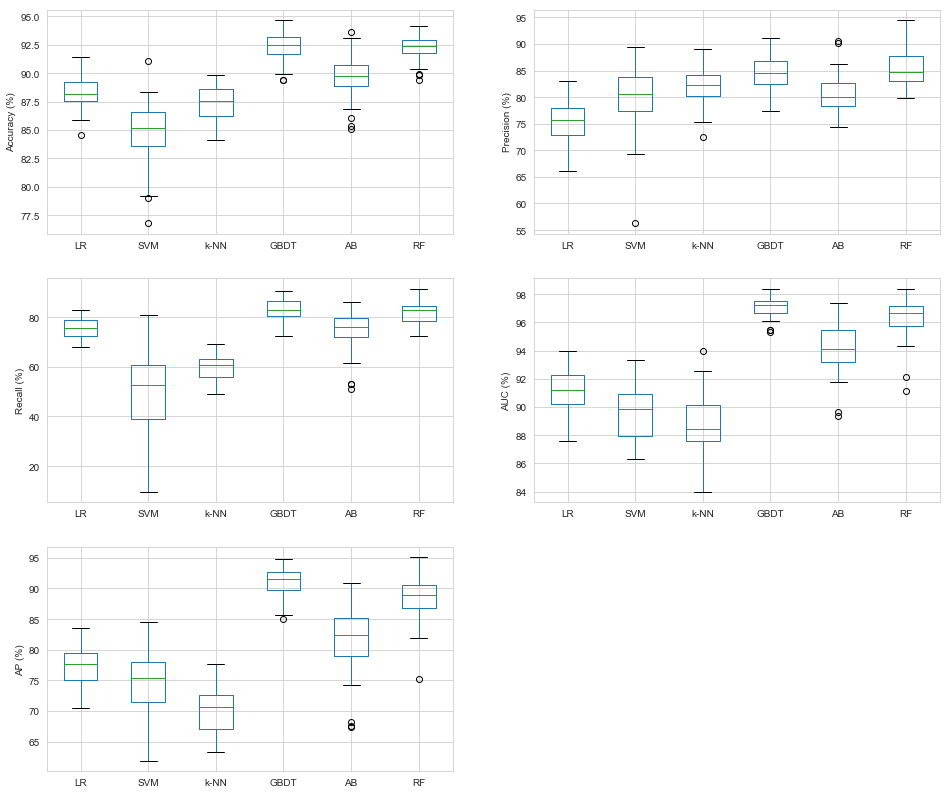

In [23]:
# Create box and whisker plots

accuracy_summary = pd.DataFrame([lr_summary["Accuracy"]*100,svm_summary["Accuracy"]*100,knn_summary["Accuracy"]*100,
                                 gb_summary["Accuracy"]*100,ab_summary["Accuracy"]*100,rf_summary["Accuracy"]*100],
                                 index = ["LR","SVM","k-NN","GBDT","AB","RF"]).transpose()

precision_summary = pd.DataFrame([lr_summary["Precision"]*100,svm_summary["Precision"]*100,knn_summary["Precision"]*100, 
                                  gb_summary["Precision"]*100,ab_summary["Precision"]*100,rf_summary["Precision"]*100],
                                  index = ["LR","SVM","k-NN","GBDT","AB","RF"]).transpose()

recall_summary = pd.DataFrame([lr_summary["Recall"]*100,svm_summary["Recall"]*100,knn_summary["Recall"]*100,
                               gb_summary["Recall"]*100,ab_summary["Recall"]*100,rf_summary["Recall"]*100],
                               index = ["LR","SVM","k-NN","GBDT","AB","RF"]).transpose()

AUC_summary = pd.DataFrame([lr_summary["AUC"]*100,svm_summary["AUC"]*100,knn_summary["AUC"]*100,
                            gb_summary["AUC"]*100,ab_summary["AUC"]*100,rf_summary["AUC"]*100],
                            index = ["LR","SVM","k-NN","GBDT","AB","RF"]).transpose()

AP_summary = pd.DataFrame([lr_summary["AP"]*100,svm_summary["AP"]*100,knn_summary["AP"]*100,
                           gb_summary["AP"]*100,ab_summary["AP"]*100,rf_summary["AP"]*100],
                           index = ["LR","SVM","k-NN","GBDT","AB","RF"]).transpose()

accuracy_summary_reindex = accuracy_summary.reset_index()
accuracy_summary_melt = pd.melt(accuracy_summary_reindex,
                                id_vars='index',
                                value_vars = ["LR","SVM","k-NN","GBDT","AB","RF"],
                                var_name = 'Algorithm',
                                value_name = 'Accuracy')

sns.set_style("whitegrid")
plt.figure(figsize=(16,14))

ax1 = plt.subplot(321)
accuracy_summary.boxplot()
plt.ylabel("Accuracy (%)")
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax2 = plt.subplot(322)
precision_summary.boxplot()
plt.ylabel("Precision (%)")
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax3 = plt.subplot(323)
recall_summary.boxplot()
plt.ylabel("Recall (%)")
for patch in ax3.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax4 = plt.subplot(324)
AUC_summary.boxplot()
plt.ylabel("AUC (%)")
for patch in ax4.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax5 = plt.subplot(325)
AP_summary.boxplot()
plt.ylabel("AP (%)")
for patch in ax5.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

plt.savefig("boxplot.png", dpi=500)
plt.show()

# 6.0. Results and analysis

In general, the ensemble techniques (i.e., GBDT, AB, and RF) consistently outperform the non-ensemble techniques (i.e., LR, SVM, and k-NN) in all evaluation metrics. This is not surprising, given the inherent characteristic of ensemble learning that improves the generalizability and robustness of the classifier. The superiority of ensemble techniques may also be due to the characteristic of the input features: five out of ten input features have a discrete/categorical nature. All ensemble classifiers examined in this paper are constructed based on information-based learning (i.e., decision trees), which is better in terms of handling discrete/categorical features. Among the ensemble techniques, AB is the least preferred because it performs the worst in all metric categories and has the highest performance dispersion. It is difficult to select the preferred classifier between GBDT and RF, due to the marginal performance disparity between them, the lack of robustness in their performance difference, and their analogous performance dispersion. GBDT is slightly preferred because it outperforms RF in all evaluation metrics, except precision. Moreover, GBDT is faster in both training and testing running time than RF.

Despite the excellent prediction performance of ensemble methods, they have three inherent drawbacks. First, ensemble classifiers have higher storage requirement than single classifiers. The storage size increases as the number of classifiers in a single ensemble expands. Second, ensemble classifiers are computationally expensive, due to the need to process multiple classifiers. Consequently, ensemble classifiers tend to have slow training time efficiency. Third, the involvement of multiple classifiers reduces the comprehensibility of the ensemble classifiers. These disadvantages are more prominent as the size of the dataset becomes larger.

It should be noticed that there is no single classifier that works best on all datasets. Despite using the same dataset, if the data pre-processing and setting are different (e.g., different selection of input features and different features’ transformation), the performance of each classifier may change. In the case of RBI, the type of assessment used (e.g., qualitative, semi-quantitative, or quantitative), the type of system being analyzed (e.g., offshore/onshore, downstream/upstream), and the type of methodology used (e.g., API, DNV, etc.) may influence the selection, as well as the performance, of the classifiers.

# References
This notebook describes the implementation of machine approach in the risk-based inspection (RBI) screening assessment, as described in the paper ['*Machine learning approach for risk-based inspection screening assessment*'](https://www.sciencedirect.com/science/article/pii/S0951832018301662).